# CS 316 : Introduction to Deep Learning - Fall 2023
## Lab 05 : Logistic Regression
### Dr. Abdul Samad

# Instructions
1. Please rename your notebook as *Lab_5_aa1234.ipynb* before the final submission. Notebooks which do not follow appropriate naming convention will not be graded.

2. Filling out the feedback form on Canvas is mandatory. Failure to do so will result in you losing 10% of your grade for this lab.

3. You have to submit this lab during the lab timings. You are allowed to submit till 11:59 PM on the day of your lab with a 30% penalty. No submissions will be accepted afterwards.

4. Please submit your own work. If you have any questions, please feel free to reach out to the course instructor or RA.

# Task Overview
Create a logisitic regression model utilising the **Portuguese financial institution** dataset to predict if a client would sign up for a term deposit. This lab has been broken into separate subtasks to make it simpler to follow.

## Setup

In [199]:
# DO NOT EDIT
import os
import numpy as np
import zipfile
import urllib.request
import tempfile
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
from IPython import display
import copy



from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

## Data Manipulation

Before you can perform logistic regression on the Portugeese financial institution dataset, you need to tranform it.

### Downloading the Dataset


The first step is downloading the data. The function `get_banking_data(directory)` which downloads the dataset is already implemented for you.

In [200]:
# DO NOT EDIT
def get_banking_dataset(directory):
    """
    Download the Bank Marketing dataset. If the file already exists, don't
    download the data again.

    Parameters:
        directory (string): The directory where you want to save "bank.csv".
    Return:
        bool : True, if the file already exists, or if you successfully downloaded the data.
    """
    dataset_link = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"
    save_path = os.path.join(directory, "bank-full.csv")
    if os.path.exists(save_path):
        return save_path
    else:
        try:
          # Create a temporary zip file and return its file descriptor and path
          fd, zipped_file_path = tempfile.mkstemp('.zip')
          # Download the file
          urllib.request.urlretrieve(dataset_link, zipped_file_path)
          # Close the file descriptor (This will allow you to delete the file after you have used it)
          os.close(fd)
          with zipfile.ZipFile(zipped_file_path, 'r') as zip_ref:
              zip_ref.extract("bank-full.csv", path = directory)
          os.remove(zipped_file_path)
          return save_path
        except:
            raise Exception(
                f"Something went wrong. Check your internet and download link.")

if not os.path.isdir("dataset"):
    os.mkdir("dataset")
dataset_folder = os.path.join("dataset")
dataset_path = get_banking_dataset(dataset_folder)

After downloading the dataset, it has already been loaded into the `df` dataframe for you by utilising the pandas library's read csv function. To gain an understanding of the dataset, the first 5 rows are printed with the df.head() method. **Each column's explanation may be found at the end of the notebook in the section titled Explanations.**

In [201]:
# DO NOT EDIT
df = pd.read_csv(dataset_path,sep=';')
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


The expected output is as follows:

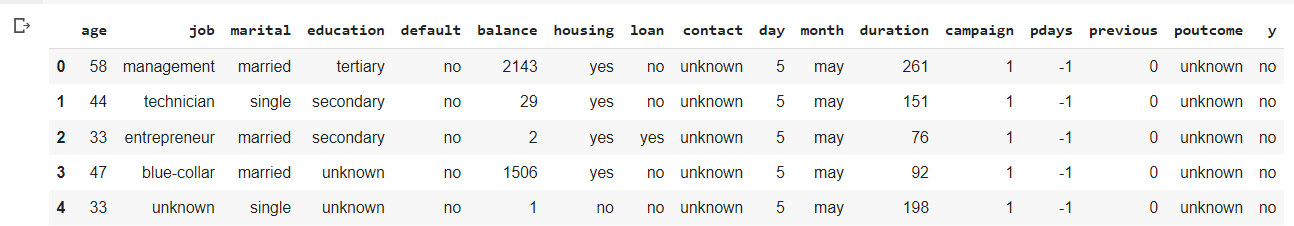



### Dropping irrelevant columns

The duration column is no longer relevant once the call has ended. Therefore, we drop the `duration` column. After the removing, the `duration` column, the first 5 rows of our new dataframe `new_df` will be as follows.

In [202]:
# DO NOT EDIT
new_df = df.drop(columns=['duration'])
new_df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


The expected output is as follows:

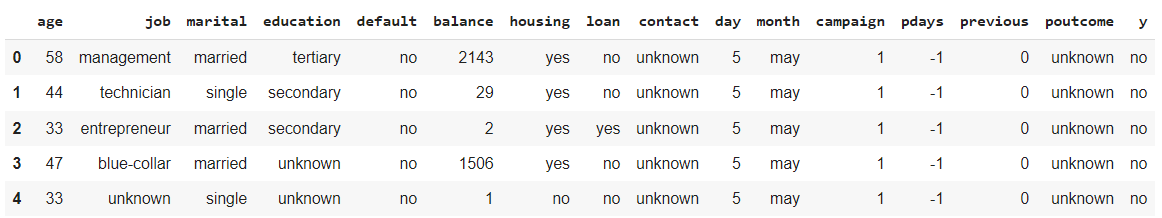

### Scaling values

The KDE Plot (Kernel Density Estimate) of each numerical column in the dataset has been plotted to get a sense of the distribution they follow. In the figure below, we can observe that the values for `balance` and `pdays` are quite large. Furthermore, `balance`, `campaign`, `pdays`, and `previous` appear to have a normal distribution.

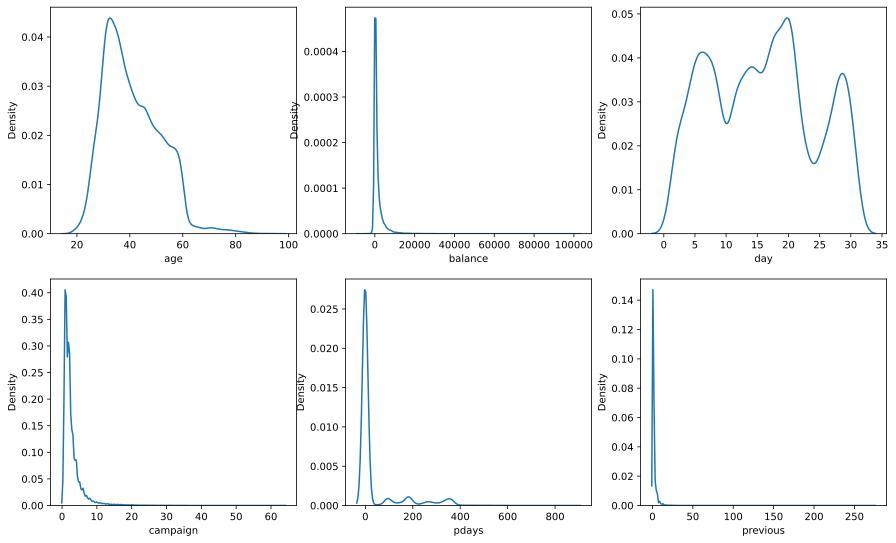

In [203]:
# DO NOT EDIT
fig, axes = plt.subplots(figsize=(15,9), ncols=3, nrows=2)
# Draw a kdeplot for each one of the columns in Dataset
i = 0
for col in new_df.columns:
    j,k = divmod(i,3)
    if new_df[col].dtypes != "object":
      sns.kdeplot(new_df[col],ax=axes[j,k])
      i +=1
plt.show()

The expected output is as follows:

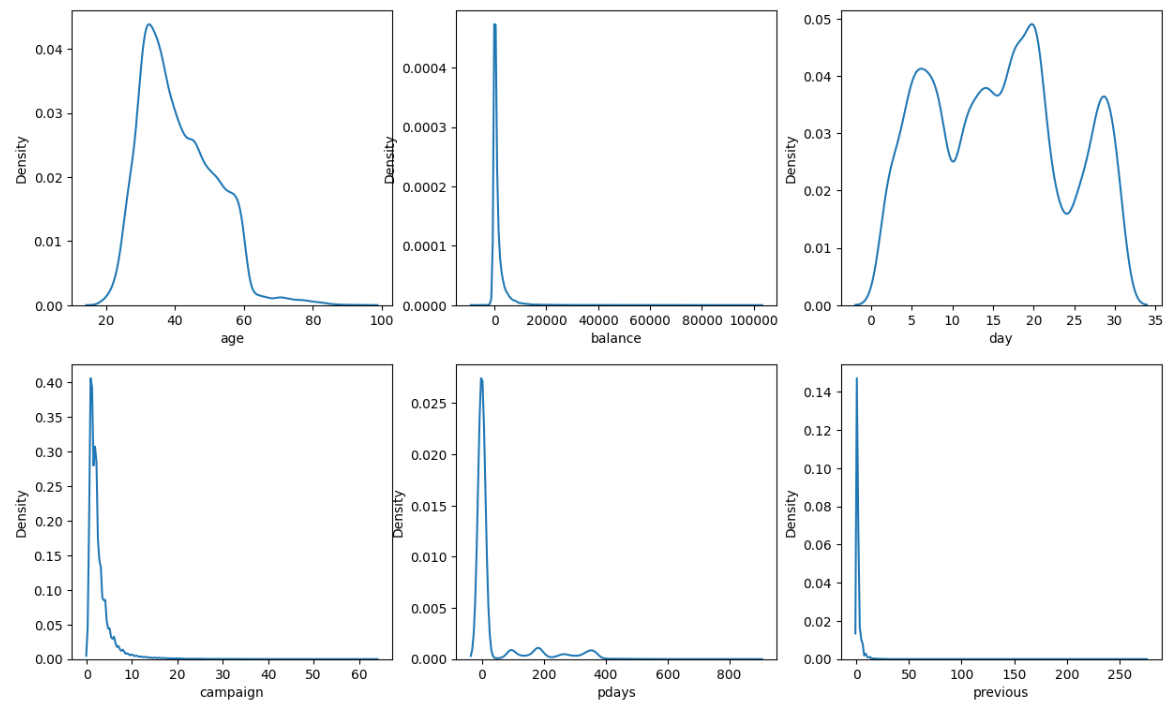

If the dataset has large values, that could result in the loss function exploding and giving nan values in the gradient which could lead to the failure of gradient descent.  Furthermore, variables measured at different scales do not contribute equally to model fitting and the model might end up creating a bias.


We can overcome these problems by using either the **Min-Max** or the **Standard Scaler**. Consequently, we should apply a **Standard Scaler** on the columns `balance`,`campaign`,`pdays` , `previous` and **Min-Max Scaler** on the columns `day` and `age`.

For any confusion regarding the **Min-Max** or **Standard** scalers, refer to the corresponding subsection in the **Explanations** section at the end of this Notebook.

In [204]:
# DO NOT EDIT
# Define Standard Transformer
standard_transformer = Pipeline(steps=[('standard', StandardScaler())])
# Define Minimax Transformer
minmax_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])
# Define processor for the processing the Data
preprocessor = ColumnTransformer(
#Pass through features not listed
remainder='passthrough',
transformers=[
("standard",standard_transformer,["balance","campaign","pdays","previous"]),
 ("minmax",minmax_transformer,["day","age"])])





### One Hot Encoding

After dealing with numerical data, we must now deal with **categorical** data before using logistic regression. One approach for dealing with categorical data is to **convert those categories into numbers** such as unknown 0, telepone 1, and so on. This approach, however, has the potential to disrupt the model because there **isn't any natural mapping of these categories to numbers**. **One-hot encoding** is the second approach for dealing with categorical data. In one-hot encoding, we create new columns, for example, one for each day of the week 'day of week mon', 'day of week tue', and so on, and one of these will have the variable 1 depending on the day of the week.The problem with **one-hot encoding** is that it introduces a lot of **Multicollinearity**, which reduces the efficacy of the model.
However, if there are more than two categories, there will be less collinearity since you will only obtain partial information instead of complete information. Furthermore, if there are just two categories, having only one column with the values 0 and 1 is ideal. As a result, we treat categorical data without adding a lot of multicollinearity.


<a href="https://www.investopedia.com/terms/m/multicollinearity.asp">What is Multicollinearity</a>



The following code can be used to determine whether columns are categorical.Categorical columns have the dtype `object`, and you may use `unique()` to determine how many categories are present, and `value counts()` to determine the frequency of each category.

In [205]:
# DO NOT EDIT
one_hot = []
one_zero = []
for column in new_df.columns:
    if new_df[column].dtype == 'object':
        unique_cat = len(new_df[column].unique())
        if unique_cat == 2:
          one_zero.append(column)
        else:
          one_hot.append(column)
        print(f"Feature '{column}' has {unique_cat} unique categories")
        print(new_df[column].value_counts())
print(f'Columns which will converted to 1 or 0: {one_zero}')
print(f'Columns which will converted using one-hot encoding: {one_hot}')


Feature 'job' has 12 unique categories
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
Feature 'marital' has 3 unique categories
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
Feature 'education' has 4 unique categories
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
Feature 'default' has 2 unique categories
no     44396
yes      815
Name: default, dtype: int64
Feature 'housing' has 2 unique categories
yes    25130
no     20081
Name: housing, dtype: int64
Feature 'loan' has 2 unique categories
no     37967
yes     7244
Name: loan, dtype: int64
Feature 'contact' has 3 unique categories
cellular     29285
unknown      13020
telephone     2906
Name: contact, dty

The partial expected output is as follows:

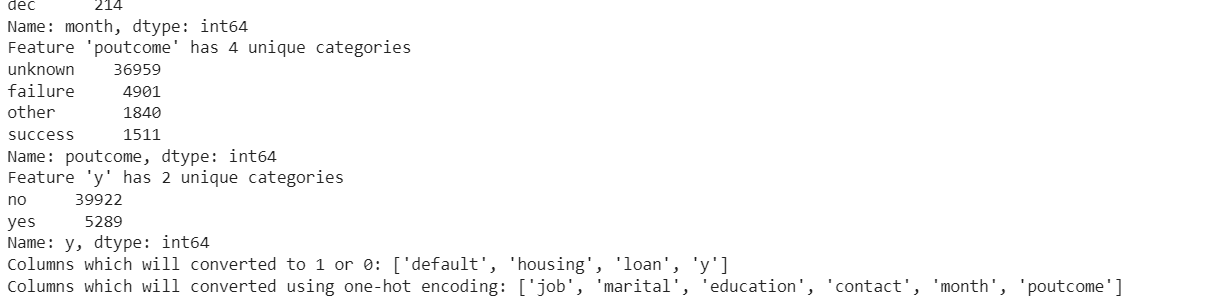

Now that you know how many categories each column contains, we can choose which columns to make into 0 and 1. In the following code snippet, `default`,`housing`,`loan`, and `y` are converted to 1 or 0.

In [206]:
# DO NOT EDIT
for col in one_zero:
  new_df[col] = [0 if x == 'no' else 1 for x in new_df[col]]

After converting all category columns with only two categories to `1` or `0`, we will use the `pd.get_dummies()` method to add one hot encoding variable to the remaining category data.

In [207]:
# DO NOT EDIT
one_hot = pd.get_dummies(new_df)
one_hot.head()

,age,default,balance,housing,loan,day,campaign,pdays,previous,y,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,0,2143,1,0,5,1,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,0,29,1,0,5,1,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,0,2,1,1,5,1,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47,0,1506,1,0,5,1,-1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,33,0,1,0,0,5,1,-1,0,0,...,0,0,1,0,0,0,0,0,0,1


The partial expected output is as follows:

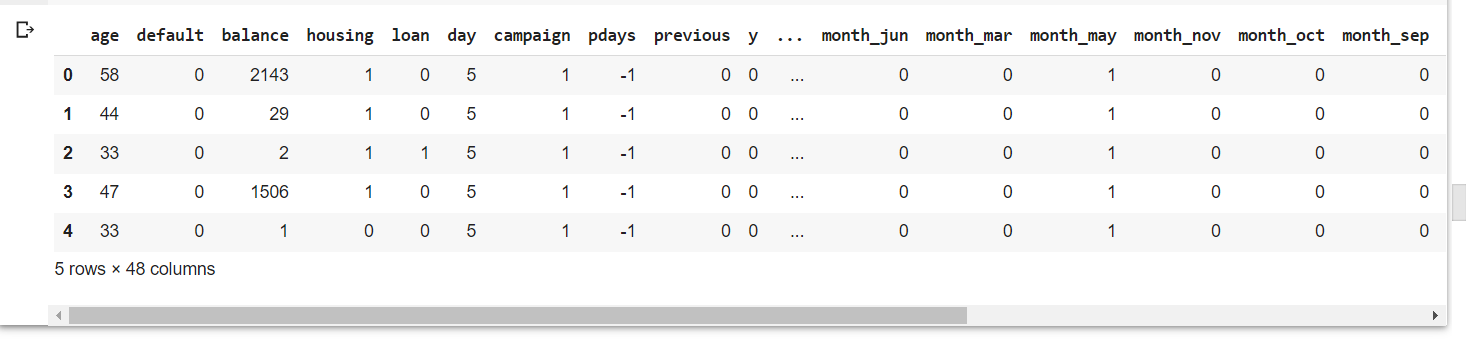

## Logistic Regression in Numpy


In the previous section you transformed the dataset for applying Logistic Regression. In this section, you will be implementing Logistic Regression in Numpy.

In [208]:
# DO NOT EDIT
Y = one_hot["y"].values.reshape(-1,1)
dataset = one_hot.drop(columns=["y"])
X = preprocessor.fit_transform(dataset)
print(X.shape)
print(Y.shape)

(45211, 47)
(45211, 1)


The expected output is as follows:

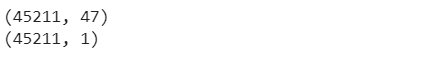

### [10 Points] Task 01 - Train Test Split

**Your task is to split the dataset into training and test dataset by completing the function `train_test_split(inputs,outputs,test_size,seed)`**

In [209]:
# TODO: Complete train_test_split
def train_test_split(inputs,outputs,test_size,seed = 0):
    """
    Split the data into training and test sets and return them as separate numpy arrays.

    Parameters:
        inputs (np.array): Input data as a numpy array.
        outputs (np.array): Output labels as a numpy array.
        test_size (float): Proportion of data to be used as test data, e.g., 0.2 means 20% of the data is for testing.
        seed (int): Seed to create a random number generator for reproducibility.

    Returns:
        tuple: A tuple containing four numpy arrays - (X_train, X_test, Y_train, Y_test), where:
        - X_train: Training input data.
        - X_test: Test input data.
        - Y_train: Training output labels.
        - Y_test: Test output labels.
    """
    rng = np.random.default_rng(seed)
    assert(len(inputs) == len(outputs))
    assert(test_size <= 1.0)
    assert(test_size >= 0.0)
    num_samples = len(inputs)
    num_train = int(num_samples * (1.0 - test_size))
    # Write your code here
    # Create index using np.arange
    index = np.arange(num_samples)

    # Shuffle the dataset using rng.shuffle
    rng.shuffle(index)

    # Split the dataset into train, test
    train = index[:num_train:]
    test = index[num_train:]
    X_train = inputs[train]
    X_test = inputs[test]
    Y_train = outputs[train]
    Y_test = outputs[test]

    return X_train, X_test, Y_train, Y_test

In [210]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
x_input = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0])
y_output = np.array([3,4,5,6,7,8,9,10,11,12])
seed = 0
split = 0.5
x_train,x_test,y_train,y_test = train_test_split(x_input,y_output,split,seed)
print(f'x_train: {x_train}, x_test: {x_test}, y_train: {y_train}, y_test: {y_test}')
assert np.allclose(x_train,np.array([5.0,7.0,3.0,8.0,4.0]))
assert np.allclose(x_test,np.array([6.0,10.0,1.0,9.0,2.0]))
assert np.allclose(y_train,np.array([ 7,  9,  5, 10,  6]))
assert np.allclose(y_test,np.array([8,12,3,11,4]))

x_train: [5. 7. 3. 8. 4.], x_test: [ 6. 10.  1.  9.  2.], y_train: [ 7  9  5 10  6], y_test: [ 8 12  3 11  4]


The expected output is as follows:

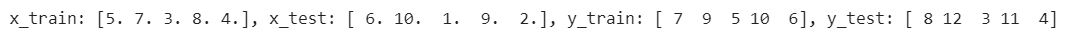

### [10 Points] Task 02 - Sigmoid Activation Function

The sigmoid function is defined as the following:
$$ \sigma(x) = \frac{1}{1+ \exp{(-x)} } $$

**Your task is  to implement the sigmoid activation by completing the `sigmoid` function.**

In [211]:
#TODO: Complete the implementation of the function sigmoid
def sigmoid(z):
  """
  Compute the sigmoid activation function.

  Parameters:
      z (numpy.ndarray or float): Input value or array.
  Returns:
      numpy.ndarray or float: The result of applying the sigmoid function to the input(s).
  """
  # Write your code here
  sigmoidd = 1/ (1 + np.exp(-z))
  return sigmoidd

<ipython-input-212-d25df41386f7>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


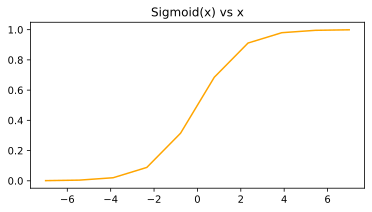

In [212]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
display.set_matplotlib_formats('svg')
x = np.linspace(-7,7,10)
result = sigmoid(x)
assert np.allclose(result,np.array([9.11051194e-04, 4.30165529e-03, 2.00575365e-02, 8.83996772e-02,3.14799023e-01, 6.85200977e-01, 9.11600323e-01, 9.79942463e-01,9.95698345e-01, 9.99088949e-01]))
plt.figure(figsize=(6, 3))
plt.plot(x,result, color='orange')
plt.title('Sigmoid(x) vs x');

The expected output is as follows:

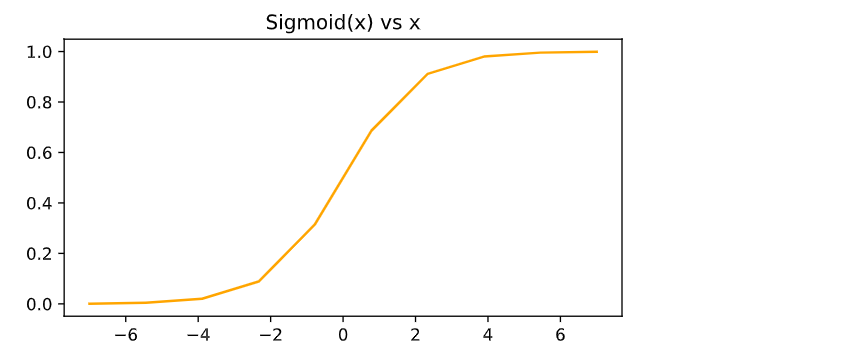

### [10 Points] Task 03 - Binary Cross Entropy Loss

The Binary Cross Entropy loss $l(\mathbf{\hat{y}},\mathbf{y})$ is defined as the following:
$$l(\mathbf{\hat{y}},\mathbf{y}) = - \frac{1}{m} \sum_i^{m} y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)$$
where $m$ is the number of examples.



**In this task, you are required to the implment Binary Cross Entropy loss by completing the `loss` function.**

---
https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a


In [213]:
#TODO: Complete the implementation of the function loss
def cross_entropy(y,y_hat,m):
    """
    Compute the binary cross-entropy loss between true labels and model predictions.

    Args:
        y (numpy.ndarray): True binary labels as a numpy array of shape (m,1).
        y_hat (numpy.ndarray): Model predictions as a numpy array of shape (m,1).
        m (int): Number of samples in the dataset.

    Returns:
        float: The binary cross-entropy loss.
    """
    # Write your code here
    crossentropy = (-1/m) * np.sum(y*np.log(y_hat)+ (1-y)*np.log(1-y_hat))
    return crossentropy



In [214]:
# DO NOT EDIT
# TEST CODE FOR CHECKING FUNCTION
print(f'm: {4}, y: {[1,0,0,0]}, y_hat: {[3.2,1.3,0.2,0.8]}')
assert cross_entropy(np.array([1,0,0,0]),sigmoid(np.array([3.2,1.3,0.2,0.8])),4) == 0.8875503305811981


m: 4, y: [1, 0, 0, 0], y_hat: [3.2, 1.3, 0.2, 0.8]


The expected output is as follows:

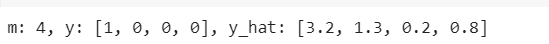

### [10 Points]  Task 04 - Linear Output

**In this task, given model weights, bias, and input values, compute the linear output by implementing the function `forward`**

In [215]:
#TODO: Complete forward
def forward(X,w,b):
    """
    Compute the output of the logistic regression model's sigmoid function.

    Parameters:
        X (numpy.ndarray): Input features as a numpy array of shape (m, n), where m is the number of samples and
                           n is the number of features.
        w (numpy.ndarray): Model weights as a numpy array of shape (n, 1), where n is the number of features.
        b (float): Model bias.

    Returns:
        numpy.ndarray: An array containing the output of the sigmoid function applied to the linear combination of
                       input features, weights, and bias.
    """
    # Write your code here
    dot_product = np.dot(X,w)
    sum = dot_product + b
    return sigmoid(sum)


In [216]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
rng = np.random.RandomState(42)
x_test = rng.uniform(size=(2,2))
w_test = np.zeros((2,1))
b_test = np.zeros(1)
split = 0.5
output_test = forward(x_test,w_test,b_test)
print(f'x: {x_test} , w: {w_test}, b: {b_test}, xw+b: {output_test}, output.shape {output_test.shape}')
assert np.array_equal(output_test,np.array([[0.5],[0.5]]))

x: [[0.37454012 0.95071431]
 [0.73199394 0.59865848]] , w: [[0.]
 [0.]], b: [0.], xw+b: [[0.5]
 [0.5]], output.shape (2, 1)


The expected output is as follows:

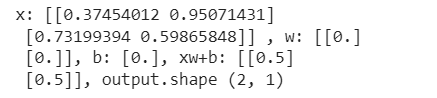

### [10 Points] Task 05 - Prediction

The output from the sigmoid is a continous value but we want to compute a discrete output. We can achieve this by comparing the output of the sigmoid value with a threshold i.e. $0.5$. This means that our predicted value is equal to 1 if sigmoid is greater than $0.5$ and otherwise 0.
$$ \hat{y}_i = \begin{cases} 1 & \sigma{(\mathbb{w}^\top \mathbb{x}_i + b)} > 0.5 \\
0 & \text{ otherwise}  \end{cases}$$

**In this task are required to compute the prediction on the dataset by completing the function `predict`.**

In [217]:
#TODO: Complete the function predict
def predict(X,w,b):
    """
    Predict binary labels based on model weights and bias.
    Parameters:
        X (numpy.ndarray): Input features as a numpy array of shape (m, n), where m is the number of samples and
                           n is the number of features.
        w (numpy.ndarray): Model weights as a numpy array of shape (n, 1), where n is the number of features.
        b (float): Model bias.

    Returns:
        numpy.ndarray: An array of binary labels (0 or 1) based on the logistic regression model's predictions.
    """
    # Write your code here
    y_hat = forward(X,w,b)
    y_hat[y_hat>0.5] = 1
    y_hat[y_hat <=0.5] = 0
    return y_hat




In [218]:
# DO NOT EDIT
# TEST CODE FOR CHECKING FUNCTION
rng = np.random.default_rng(10)
w_test = rng.uniform(0,0.5,(2,1))
x_test = rng.uniform(0,0.5,(2,2))
b_test = rng.uniform(0,0.5,1)
pred_test = predict(x_test,w_test,b_test)
print(f'w: {w_test}, b: {b_test}, x: {x_test}, y_pred: {pred_test}')
assert np.array_equal(pred_test,np.array([[True],[True]]))


w: [[0.47800085]
 [0.10384091]], b: [0.34451824], x: [[0.41422244 0.07464106]
 [0.25640231 0.0679598 ]], y_pred: [[1.]
 [1.]]


The expected output is as follows:

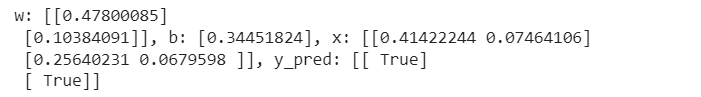

### [10 Points] Task 06 - Initialise Model



**In this task you are required to initialse the model weights and bias by implementing the function `initialise_model`.**

In [219]:
# TODO: Complete initialise_model
def initialise_model(n):
    """
    Initialize the model weights and bias for a binary classification model.

    Args:
        n (int): Number of features.

    Returns:
        tuple: A tuple containing the model weights 'w', a numpy array of dimensions (n, 1) initialized with zeros,
               and the bias 'b', a scalar initialized with the value 0.
    """
    # Write your code here.
    w = np.zeros((n,1))
    b = np.zeros(1)
    return w,b

In [220]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION.
w_test,b_test = initialise_model(5)
print(f'w: {w_test}, w.shape: {w_test.shape}, b: {b_test}, b.shape {b_test.shape}')
assert np.array_equal(w_test,np.array([[0.],[0.],[0.],[0.],[0.]]))
assert np.array_equal(b_test,np.array([0.]))

w: [[0.]
 [0.]
 [0.]
 [0.]
 [0.]], w.shape: (5, 1), b: [0.], b.shape (1,)


The expected output is as follows:

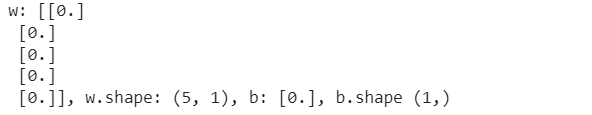

### [10 Points] Task 07 - Gradient Descent

$ \frac{\delta l(\mathbf{y},\mathbf{\hat{y}}) }{\delta w} = \frac{1}{m} \mathbf{X}^T (\mathbf{\hat{y}} - \mathbf{y})  $

$ \frac{\delta l(\mathbf{y},\mathbf{\hat{y}}) }{\delta b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) $


**In this task you have to compute the gradient of the model weight and bias
with respect to the loss function by implementing the function `gradient_descent`**

In [221]:
#TODO: Complete mean_squared_error
def gradient_descent(X, y, w, b, m):
    """
    Compute the gradients of the binary cross-entropy loss with respect to model parameters (weights and bias)
    for use in gradient descent.
    Parameters:
        X (np.array): Input features as a numpy array of shape (m, n), where m is the number of samples and n is the
                      number of features.
        y (np.array): True output labels as a numpy array of shape (m,1).
        w (np.array): Model weights as a numpy array of shape (n,1).
        b (float): Model bias.
        m (int): Number of samples in the dataset.

    Returns:
        tuple: A tuple containing the gradients of the loss with respect to weights (grad_w) and bias (grad_b).
    """
    sum = forward(X,w,b)
    a = sum - y
    b = X.T @ a
    grad_w = 1/m * b
    grad_b = 1/m * np.sum(a)
    return grad_w, grad_b


In [222]:
# DO NOT EDIT
# TEST CODE FOR CHECKING THE FUNCTION
X_sample = np.array([[1, 2], [2, 3], [3, 4]])
y_sample = np.array([0, 1, 0])
w_sample = np.array([0.5, -0.5])
b_sample = 0.2
m_sample = len(y_sample)
# Compute gradients using the function
grad_w, grad_b = gradient_descent(X_sample, y_sample, w_sample, b_sample, m_sample)
assert np.allclose(grad_w,np.array([0.1844483 , 0.27667245]))
assert np.allclose(grad_b,0.09222414985500771)
print(f'grad_w: {grad_w}, grad_b: {grad_b}')

grad_w: [0.1844483  0.27667245], grad_b: 0.09222414985500771


The expected output is as follows:

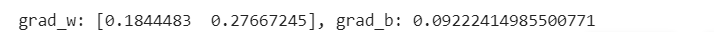

### [10 Points] Task 08 -  Training Loop




**In the preceding tasks, you implemented different submodules. In this task you are required to the implement the main training loop for training a logistic regression model by completing the function `main`**.

In [223]:
#TODO: Complete the function main
def main(X, y, num_epochs, lr):
    """
    Trains a binary classification model and returns the final model weights and bias. Additionally, it plots a graph
    of the number of epochs vs. the binary cross-entropy loss.
    Parameters:
        X (np.array): Input features as a numpy array of shape (m, n), where m is the number of samples and n is the
                      number of features.
        y (np.array): Output labels as a numpy array of shape (m,1).
        num_epochs (int): Number of training epochs.
        lr (float): Learning rate for gradient descent.
    Returns:
        tuple: A tuple containing the final model weights (w) and bias (b).
    Note:
        The function splits the input data into a training set and a test set with a 0.2 split ratio and uses a seed of 0
        for random splitting.

    """
    # Split the data into train & test dataset. Split should 0.2 and seed should be equal to 0
    X_train,X_test,Y_train,Y_test = train_test_split(X,y,0.2,0)
    # Initialize Weights
    w,b = initialise_model(X_train.shape[1])
    # Initialise empty L list
    L = []
    # Main Loop
    for epoch in range(num_epochs+1):
        # Write your code here
        n = len(X_train)
        # Compute the linear output using the training data
        Y_hat = forward(X_train,w,b)
        # Compute the loss on the training output
        loss = cross_entropy(Y_train,Y_hat,n)
        # Store loss value in Python list
        L.append(loss)
        if epoch % 10 == 0:
          print(f'Epoch: {epoch}, loss: {loss}')
        # Compute grad_w, grad_b
        grad_w, grad_b = gradient_descent(X_train,Y_train,w,b,n)
        # Update w,b
        w -= lr * grad_w
        b -= lr * grad_b
        # END SOLUTION.
    # Plot
    plt.plot([epoch for epoch in range(num_epochs+1)],L)
    plt.xlabel('Epochs')
    plt.ylabel('Binary Cross Entropy Loss')
    plt.title('Epochs vs Binary Cross Entropy Loss')
    plt.show()
    return w,b

Epoch: 0, loss: 0.6931471805599453
Epoch: 10, loss: 0.3377900725283147
Epoch: 20, loss: 0.33121650839026545
Epoch: 30, loss: 0.327290466042766
Epoch: 40, loss: 0.3243857547267729
Epoch: 50, loss: 0.3221060404706894


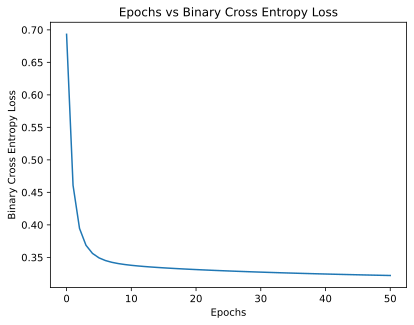

In [224]:
w_act, b_act = main(X,Y,50,0.5)
assert np.allclose(b_act,np.array([-0.49015197]))
assert np.allclose(w_act, np.array([[ 7.93486900e-02],[-2.38947971e-01],[ 6.39134684e-02],[ 7.08786805e-02],[-2.28559867e-01],[-1.26680202e-01],[-2.58393962e-02],[-5.05396074e-01],[-1.91069847e-01],[-5.03789287e-02],[-2.11225298e-01],[-4.04062919e-02],[-3.69389799e-02],[-7.23335614e-02],[ 7.78189003e-02],[-2.61714745e-02],[-8.08521318e-02],[ 4.78323483e-02],[-8.92137704e-02],[-2.89688362e-04],[-7.99309202e-03],[-9.42491969e-02],[-3.52862677e-01],[-4.30400944e-02],[-1.62389406e-01],[-2.52952859e-01],[-4.60463115e-02],[-2.87633921e-02],[-2.63561101e-02],[-3.94216838e-02],[-4.24374175e-01],[ 5.37988971e-02],[-1.19670210e-01],[ 2.84571634e-02],[-2.75302686e-02],[-5.18284440e-02],[-1.20622175e-01],[-8.58255479e-02],[ 8.57816393e-02],[-3.09769229e-01],[-1.12087072e-01],[ 9.27229984e-02],[ 7.64202790e-02],[-1.93056038e-01],[-5.31913577e-02],[ 3.02141580e-01],[-5.46046153e-01]]))

The expected output is as follows:


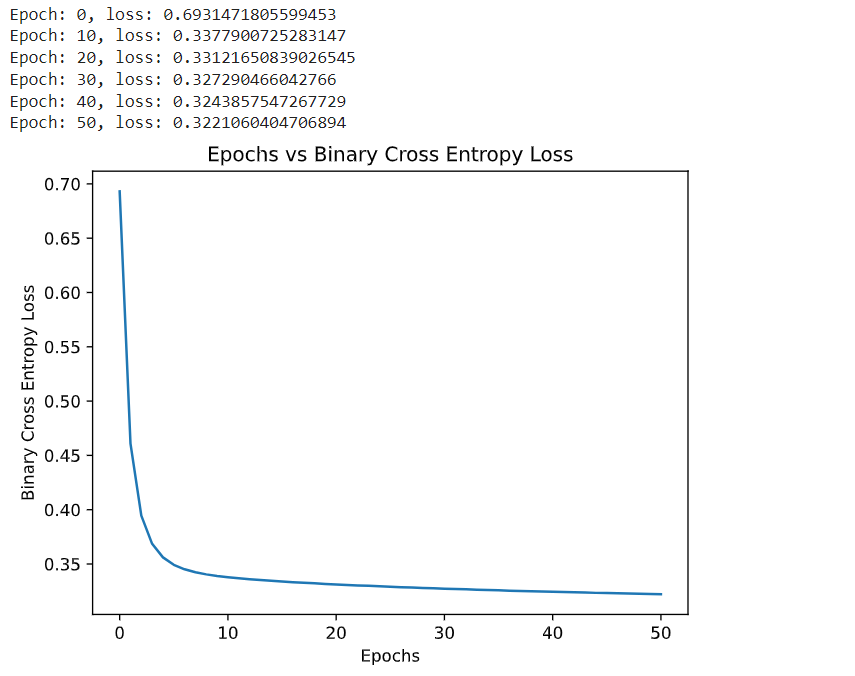

### [10 Points] Task 09 - Evaluating the model

**In this task, you must compute the accuracy on the test dataset using the trained logistic regression model by implementing the function `compute_accuracy(X_test,Y_test,w,b)`**

In [225]:
#TODO: Compute accuracy
def compute_accuracy(X_test, Y_test, w, b):
    """
    Compute the accuracy of a binary classification model.

    Parameters:
    X_test (numpy.ndarray): Test data features of shape (m, n), where m is the number of samples and n is the number of features.
    Y_test (numpy.ndarray): True labels for the test data, shape (m,).
    w (numpy.ndarray): Model weights of shape (n,).
    b (float): Model bias.

    Returns:
    float: The accuracy of the model on the test data, as a percentage.
    """
    # Write your code here
    # predictions = np.dot(X_test,w) + b
    # labels = (predictions>=0.5).astype(int)
    # accuracy = (labels==Y_test).mean() * 100
    # return accuracy
    Y_hat = predict(X_test,w,b)
    accuracy = np.mean(Y_hat==Y_test)
    return accuracy


In [226]:
# DO NOT EDIT
# TEST CODE FOR CHECKING FUNCTION
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,0.2,0)
result = compute_accuracy(X_test,Y_test,w_act,b_act)
print(f"The model accuracy is equal to {(result*100):.2f}%")
assert result == 0.8847727524051753

The model accuracy is equal to 88.48%


The expected output is as follows:


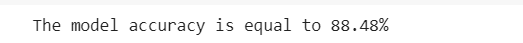

This is the code to make a confusion matrix.


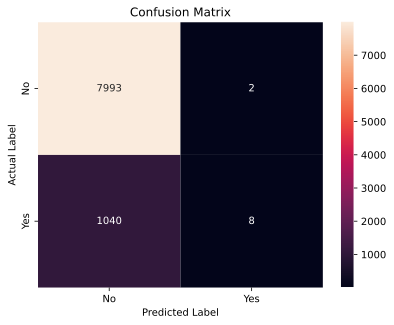

In [227]:
# DO NOT EDIT
cm=confusion_matrix(Y_test, predict(X_test,w_act,b_act))
class_label = ["No", "Yes"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt= "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

The expected output is as follows:

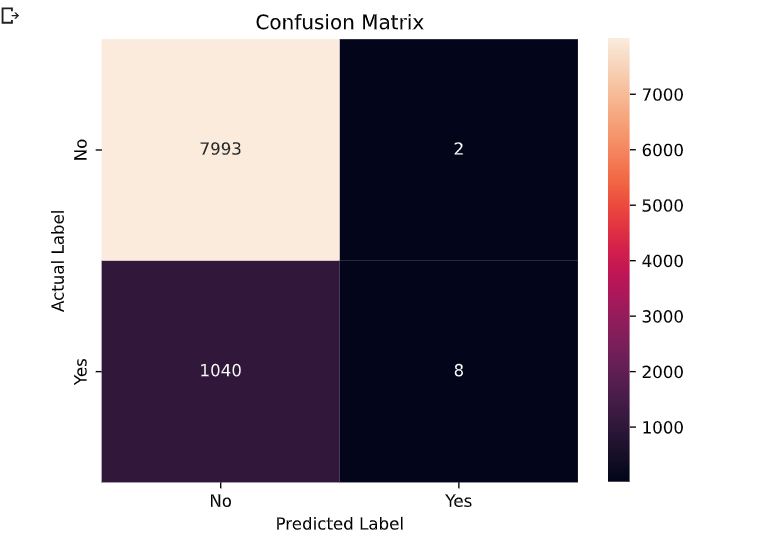

# Explanations

## Dataset details

1.  **`age`** (numeric)
2. **`job`** : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")
3.  **`marital`** : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4.  **`education`** (categorical: "unknown","secondary","primary","tertiary")
5.  **`default`**: has credit in default? (binary: "yes","no")
6.  **`balance`**: average yearly balance, in euros (numeric)
7.  **`housing`**: has housing loan? (binary: "yes","no")
8.  **`loan`**: has personal loan? (binary: "yes","no")
9.  **`contact`**: contact communication type (categorical: "unknown","telephone","cellular")
10.  **`day`**: last contact day of the month (numeric)
11.  **`month`**: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12.  **`duration`**: last contact duration, in seconds (numeric)
13.  **`campaign`**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14.  **`pdays`**: number of days that passed by after the client was last contacted from a previous campaign (numeric,. 1 means client was not previously contacted)
15.  **`previous`**: number of contacts performed before this campaign and for this client (numeric)
16.  **`poutcome`**: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
17.  **`y`** has the client subscribed a term deposit? (binary: "yes","no")

---


Note: pd.get_dummies has an option of drop_first, this makes it that if you have 5 categories, it only makes 4 columns, not 5. It drops the first one. That can be pretty useful but was not expected for this lab.

## Min-Max and Standard Scalar



The **Min-Max Scalar** is mathematically defined as the following:
$$X_{norm} = \frac{X-X_{min}}{X_{max}- X_{min}}$$

It **brings data into the range of $[0,1]$** and  fixes the problem of having large values without changing the shape of the distribution.


The **Standard Scalar** makes the **mean of the data 0 and the variance 1**. It is like like the standard normal distribution in terms of mean and variance but the resultant distribution may not be normal. However, it is useful since deep learning algorithms often call for zero mean and unit variance. Morover, we should use it when our distribution is normal.





https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html


## One-hot encoding



Some algorithms can work with categorical data directly.

For example, a decision tree can be learned directly from categorical data with no data transform required (this depends on the specific implementation).

Many machine learning algorithms cannot operate on label data directly. They require all input variables and output variables to be numeric.

In general, this is mostly a constraint of the efficient implementation of machine learning algorithms rather than hard limitations on the algorithms themselves.

This means that categorical data must be converted to a numerical form. If the categorical variable is an output variable, you may also want to convert predictions by the model back into a categorical form in order to present them or use them in some application.

For categorical variables where no such ordinal relationship exists, the integer encoding is not enough.

In fact, using this encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

In this case, a one-hot encoding can be applied to the integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.



## Accuracy

**We must see how good we are at predicting a class.**

There are other metrics available:

1. **Sensitivity/recall : how good a test is at detecting the positives**. A test can cheat and maximize this by always returning “positive”.

2. **Specificity : how good a test is at dedecting the negatives.** A test can cheat and maximize this by always returning “negative”.

3. **Precision : how many of the positively classified were relevant.**

4. F- score: It is difficult to compare two models with low precision and high recall or vice versa. So to make them comparable, we have another metric, F-Score. It helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.
$$\text{F - score} =2 \frac{\text{recall}\times \text{precision}}{\text{recall}+ \text{precision}}$$


So **we can use F score to see how good the model is, the higher the better.**



## Confusion Matrix




it is a performance measurement for machine learning classification problem where output can be two or more classes, in our case,  In the binary case, it is a table with 4 different combinations of predicted and actual values.

![https://miro.medium.com/max/445/1*Z54JgbS4DUwWSknhDCvNTQ.png](https://miro.medium.com/max/445/1*Z54JgbS4DUwWSknhDCvNTQ.png)

![](https://miro.medium.com/max/578/1*7EYylA6XlXSGBCF77j_rOA.png)

**The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.**

It shows the ways in which your classification model is confused when it makes predictions and gives us insight to the type of errors the classifier is making.An ideal model should have highest values in the diagonal (predictions for each class are accurate)
